In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from datetime import timedelta

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

-Design a query to retrieve the last 12 months of precipitation data and plot the results

-Calculate the date 1 year ago from the last data point in the database

-Perform a query to retrieve the data and precipitation scores

-Save the query results as a Pandas DataFrame and set the index to the date column

-Sort the dataframe by date

-Use Pandas Plotting with Matplotlib to plot the data

In [11]:
engine.execute("select * from measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [13]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
last_date

'2017-08-23'

In [16]:
datetime_date=dt.datetime.strptime(last_date,"%Y-%m-%d")
one_year_ago = datetime_date - timedelta(days=365)
one_year_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [22]:
datetime_date

datetime.datetime(2017, 8, 23, 0, 0)

In [17]:
last_year_prcp=session.query(Measurement.station,Measurement.date, Measurement.prcp).filter(Measurement.date>='2016-08-23').order_by(Measurement.date).all()

In [18]:
date_prcp=session.query(Measurement.date, func.avg(Measurement.prcp)).filter(Measurement.date>='2016-08-23').\
order_by(Measurement.date).group_by(Measurement.date).all()

In [19]:
date_prcp[0][0]

'2016-08-23'

In [20]:
len(date_prcp)

366

In [21]:
dates=[date_prcp[i][0] for i in range(len(date_prcp))]
prcps = [date_prcp[j][1] for j in range(len(date_prcp))]

In [23]:
precipitation_df = pd.DataFrame(list(zip(dates, prcps)), 
               columns =['Date', 'Precipitation']) 
precipitation_df.head()

,Date,Precipitation
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000


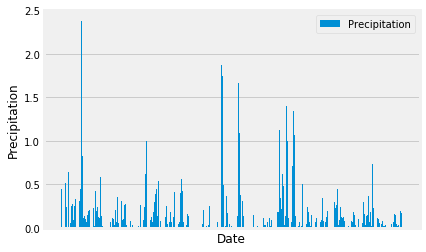

In [24]:
plt.bar(dates,prcps)
plt.xticks([])
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend(['Precipitation'])
plt.savefig("Images/Precipitation.png")
plt.show()

In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
describe_precipptation=precipitation_df.describe()
describe_precipptation

,Precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [26]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [27]:
# What are the most active stations? (i.e. what stations have the most rows)? 'USC00519281'
# List the stations and the counts in descending order.

station_rows=session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
station_rows

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station=session.query(Station.id).filter(Station.station == "USC00519281").all()
most_active_station

[(7)]

In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Station.id==7).all()

[(53.0, 87.0, 73.09795396419437)]

In [30]:
session.query(Measurement.station,func.max(Measurement.tobs)).all()

[('USC00519397', 87.0)]

In [31]:
highest_temp_station=session.query(Measurement.date,Measurement.station, Measurement.tobs).\
filter(Measurement.date>='2016-08-23').\
filter(Measurement.station == "USC00519397").\
order_by(Measurement.date).all()


In [32]:
highest_temp_station_df=pd.DataFrame(highest_temp_station)
highest_temp_station_df.head()

,date,station,tobs
0,2016-08-23,USC00519397,81.0
1,2016-08-24,USC00519397,79.0
2,2016-08-25,USC00519397,80.0
3,2016-08-26,USC00519397,79.0
4,2016-08-27,USC00519397,77.0


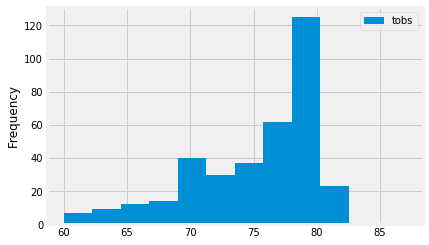

In [33]:
highest_temp_station_df.plot.hist(by='station', bins=12)
plt.savefig("Images/tobs_histogram.png")

In [34]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [35]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_temp=calc_temps('2017-06-30', '2017-07-07')
my_trip_temp

[(74.0, 77.80851063829788, 87.0)]

In [36]:
my_trip_df = pd.DataFrame(my_trip_temp, columns=["Min","Avg","Max"])
my_trip_df

,Min,Avg,Max
0,74.0,77.808511,87.0


In [37]:
y_error = my_trip_df["Max"]-my_trip_df["Min"]
avg_temp = my_trip_df["Avg"]
print(y_error)
print(avg_temp)
print(my_trip_df["Max"])
print(my_trip_df["Min"])

0    13.0
dtype: float64
0    77.808511
Name: Avg, dtype: float64
0    87.0
Name: Max, dtype: float64
0    74.0
Name: Min, dtype: float64


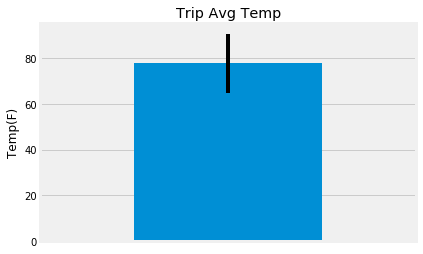

In [38]:
avg_temp.plot(kind="bar",yerr=y_error)
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.xticks([])
plt.savefig("Images/my_trip_temp.png")
plt.show()

In [39]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
filter(Measurement.date >= '2017-06-30').filter(Measurement.date <= '2017-07-07').\
filter(Station.station==Measurement.station).\
group_by(Measurement.station).\
order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.5200000000000002),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.65),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.33000000000000007),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.2),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.12),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.09000000000000001),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.0)]